Checking for NaN values in the dataset:
Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64
Any NaN in scaled data: False
Any Inf values in scaled data: False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1895
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1707 
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1710 
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1665 
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1534
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1614
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1339
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1423
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1213
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1064 
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1269
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1120
Epoch 13/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1076
Epoch 14/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1129 
Epoch 15/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1035
Epoch 16/150
3

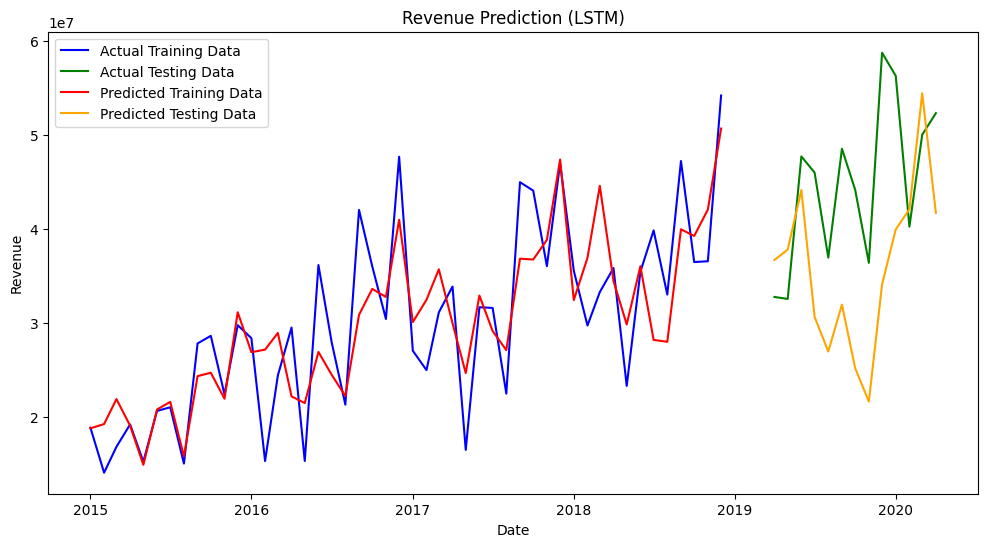

In [27]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.optimizers import Adam
import pandas as pd

# Load the dataset
file_path = '/content/Month_Value_1.csv'
data = pd.read_csv(file_path)

# Convert 'Period' to datetime
data['Period'] = pd.to_datetime(data['Period'], format='%d.%m.%Y')

# Check for NaN values in the dataset
print("Checking for NaN values in the dataset:")
print(data.isna().sum())  # Check how many NaN values there are in each column

# Handle NaN values: Drop rows with NaN values
data = data.dropna()

# Replace zeros in numerical columns with small positive values to avoid issues during scaling
data[["Sales_quantity", "Average_cost", "The_average_annual_payroll_of_the_region"]] = data[["Sales_quantity", "Average_cost", "The_average_annual_payroll_of_the_region"]].replace(0, 0.0001)

# We will use 'Revenue' as the target and the other columns as features
features = ['Sales_quantity', 'Average_cost', 'The_average_annual_payroll_of_the_region']
target = 'Revenue'

# Scaling the data (MinMax scaling to range between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])

# Check for NaN or Inf values in the scaled data after scaling
print(f"Any NaN in scaled data: {np.any(np.isnan(scaled_data))}")
print(f"Any Inf values in scaled data: {np.any(np.isinf(scaled_data))}")

# Prepare the data for LSTM: create time series sequences
time_step = 3  # Using 3 time steps as the window size
x_data, y_data = [], []

for i in range(time_step, len(scaled_data)):
    x_data.append(scaled_data[i-time_step:i, :-1])  # Features (excluding target)
    y_data.append(scaled_data[i, -1])  # Target ('Revenue')

x_data, y_data = np.array(x_data), np.array(y_data)

# Split into training and testing sets
train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Reshape data for LSTM (LSTM expects 3D input: [samples, time steps, features])
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

# Build the LSTM model with more units and layers for better learning
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))  # Add another dropout layer
model.add(GRU(units=50))  # Adding a GRU layer as an alternative
model.add(Dense(units=1))  # Output layer with 1 unit (for prediction of 'Revenue')

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=150, batch_size=16)  # Increased epochs

# Predict the results
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Inverse transform the predictions and actual values
train_pred = scaler.inverse_transform(np.concatenate((np.zeros((train_pred.shape[0], 3)), train_pred), axis=1))[:, -1]
y_train_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_train.shape[0], 3)), y_train.reshape(-1, 1)), axis=1))[:, -1]

test_pred = scaler.inverse_transform(np.concatenate((np.zeros((test_pred.shape[0], 3)), test_pred), axis=1))[:, -1]
y_test_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Plotting the predictions
plt.figure(figsize=(12, 6))

# Plot the actual training data (up to the actual training length)
plt.plot(data['Period'][:len(y_train_actual)], y_train_actual, color='blue', label='Actual Training Data')

# Plot the actual testing data (from train_size + time_step onward)
plt.plot(data['Period'][train_size + time_step:], y_test_actual, color='green', label='Actual Testing Data')

# Plot the predicted training data (up to the actual training length)
plt.plot(data['Period'][:len(train_pred)], train_pred, color='red', label='Predicted Training Data')

# Plot the predicted testing data (from train_size + time_step onward)
plt.plot(data['Period'][train_size + time_step:], test_pred, color='orange', label='Predicted Testing Data')

plt.title('Revenue Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()